In [1]:
import numpy as np
import random
from tqdm import tqdm
np.random.seed(20190409)
random.seed(20190409)

In [2]:
def create_dataset():
    N, d = 1100, 2
    W = np.random.random((d, 1)) - 0.5
    b = np.random.random(1) - 0.5
    
    def random_line(x):
        labels = np.array(np.matmul(W.transpose(), D.transpose()) + b >= 0,
                          dtype=np.int)
        labels = labels.squeeze()
        return labels
    
    D = np.random.random(size=(N, d))
    Y = random_line(D)
    for index in random.sample(list(range(N)), N // 10):
        Y[index] = abs(Y[index] - 1)
    
    N_train = 100
    indices = np.array(np.random.random_sample(size=1100) > 0.5, dtype=np.int)
    train_indices = [index for index, value in enumerate(indices) if value == 1][:N_train]
    dev_indices = [index for index, _ in enumerate(indices) if index not in train_indices]

    train_x, train_y = [], []
    dev_x, dev_y = [], []
    D, Y = D.tolist(), Y.tolist()
    for index in train_indices:
        train_x.append(D[index])
        train_y.append(Y[index])
    for index in dev_indices:
        dev_x.append(D[index])
        dev_y.append(Y[index])
    train_x, train_y = np.array(train_x), np.array(train_y)
    dev_x, dev_y = np.array(dev_x), np.array(dev_y)
    return (train_x, train_y), (dev_x, dev_y)

In [3]:
def evaluate(x, y, W, b):
    N, _ = x.shape
    preds = np.array(np.matmul(W.transpose(), x.transpose()) + b >= 0,
                     dtype=np.int)
    preds = preds.squeeze()
    errors = sum(preds != y)
    return errors / N

In [4]:
def pla(x, y, W, b):
    N, _ = x.shape
    preds = np.array(np.matmul(W.transpose(), x.transpose()) + b >= 0,
                     dtype=np.int)
    preds = preds.squeeze()
    misclassifieds = random.sample(np.arange(N)[preds != y].tolist(), 1)
    if len(misclassifieds) == 0:
        return W, b
    else:
        index = misclassifieds[0]
        ins_x, ins_y = x[index], y[index]
        if ins_y == 0:
            ins_y = -1
        W = W + (ins_y * ins_x)[np.newaxis, :].transpose()
        b = b + ins_y
        return W, b

In [5]:
def pocket_alg(dataset, T=1000):
    (train_x, train_y), (dev_x, dev_y) = dataset
    N, d = train_x.shape
    W = np.zeros((d, 1))
    b = np.random.random(1)
    W_best, b_best = W.copy(), b.copy()
    err_best = evaluate(train_x, train_y, W, b)
    errs, errs_best = [err_best], [err_best]
    test_err_best = evaluate(dev_x, dev_y, W, b)
    test_errs, test_errs_best = [test_err_best], [test_err_best]
    for t in range(T-1):
        W, b = pla(train_x, train_y, W, b)
        err = evaluate(train_x, train_y, W, b)
        if err_best is None or err < err_best:
            err_best = err
            W_best, b_best = W.copy(), b.copy()
        errs.append(err)
        errs_best.append(err_best)
        
        test_err = evaluate(dev_x, dev_y, W, b)
        test_errs.append(test_err)
        test_err_best = evaluate(dev_x, dev_y, W_best, b_best)
        test_errs_best.append(test_err_best)
    return (errs, errs_best), (test_errs, test_errs_best)

In [6]:
def repeat(dataset, times, T):
    arr_train_errs, arr_train_errs_best = np.zeros(T), np.zeros(T)
    arr_test_errs, arr_test_errs_best = np.zeros(T), np.zeros(T)
    for _ in tqdm(range(times)):
        (train_errs, train_errs_best), (test_errs, test_errs_best) = pocket_alg(dataset, T=T)
        arr_train_errs += train_errs
        arr_train_errs_best += train_errs_best
        arr_test_errs += test_errs
        arr_test_errs_best += test_errs_best
    arr_train_errs /= times
    arr_train_errs_best /= times
    arr_test_errs /= times
    arr_test_errs_best /= times
    return (arr_train_errs, arr_train_errs_best), (arr_test_errs, arr_test_errs_best)

In [7]:
dataset = create_dataset()

In [8]:
errs = repeat(dataset, times=20, T=1000)

100%|██████████| 20/20 [03:35<00:00, 10.76s/it]


In [9]:
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

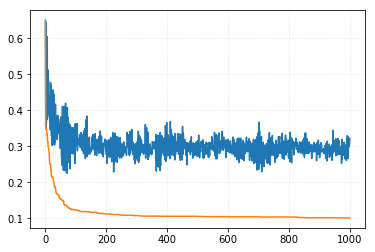

In [11]:
X = np.arange(1000)
(train_errs, train_errs_best), _ = errs
plt.plot(X, train_errs)
plt.plot(X, train_errs_best)
plt.grid(alpha=0.4,linestyle=':')
plt.show()

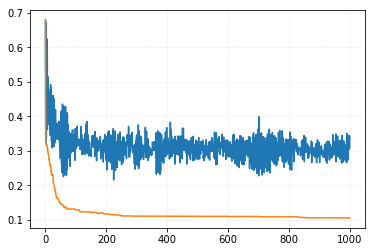

In [12]:
X = np.arange(1000)
_, (test_errs, test_errs_best) = errs
plt.plot(X, test_errs)
plt.plot(X, test_errs_best)
plt.grid(alpha=0.4,linestyle=':')
plt.show()

In [13]:
train_errs[:10]

array([0.65  , 0.35  , 0.645 , 0.3625, 0.602 , 0.3735, 0.6045, 0.381 ,
       0.512 , 0.4115])

In [14]:
train_errs_best[:10]

array([0.65  , 0.35  , 0.35  , 0.345 , 0.345 , 0.333 , 0.333 , 0.3125,
       0.3125, 0.298 ])

In [15]:
test_errs[:10]

array([0.679  , 0.321  , 0.6737 , 0.33625, 0.621  , 0.36145, 0.62425,
       0.38205, 0.5151 , 0.42735])

In [16]:
test_errs_best[:10]

array([0.679  , 0.321  , 0.321  , 0.32065, 0.32065, 0.31465, 0.31465,
       0.30235, 0.30235, 0.28955])